# **Tareas: Procesamiento de señal y de la imagen**
## Procesamiento de Imagen y Señal
### **Alan García Justel**
### Curso 2024-2025

In [2]:
import math
import cmath

import os
import sys

##

import warnings
warnings.filterwarnings('ignore')

##

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as im

import plotly
import plotly.express as px

from itertools import cycle

from scipy import signal, fftpack, ndimage

from scipy.signal import chirp, spectrogram

import scipy.signal as sp_s
import scipy.io as sp_io

##

from skimage import io, exposure, filters, transform

from skimage.morphology import disk

from PIL import Image, ImageEnhance, ImageFilter, ImageOps

##

import requests
import urllib.request

### Audio
import IPython.display as ipd
import librosa
import librosa.display

import soundfile as sf

In [3]:
def audio_player_list(signals, rates, width=270, height=40, columns=None, column_align='center'):
    """Generate a list of HTML audio players tags for a given list of audio signals.

    Notebook: B/B_PythonAudio.ipynb

    Args:
        signals (list): List of audio signals
        rates (list): List of sample rates
        width (int): Width of player (either number or list) (Default value = 270)
        height (int): Height of player (either number or list) (Default value = 40)
        columns (list): Column headings (Default value = None)
        column_align (str): Left, center, right (Default value = 'center')
    """
    pd.set_option('display.max_colwidth', None)

    if isinstance(width, int):
        width = [width] * len(signals)
    if isinstance(height, int):
        height = [height] * len(signals)

    audio_list = []
    for cur_x, cur_Fs, cur_width, cur_height in zip(signals, rates, width, height):
        audio_html = ipd.Audio(data=cur_x, rate=cur_Fs)._repr_html_()
        audio_html = audio_html.replace('\n', '').strip()
        audio_html = audio_html.replace('<audio ', f'<audio style="width: {cur_width}px; height: {cur_height}px" ')
        audio_list.append([audio_html])

    df = pd.DataFrame(audio_list, index=columns).T
    table_html = df.to_html(escape=False, index=False, header=bool(columns))
    table_html = table_html.replace('<th>', f'<th style="text-align: {column_align}">')
    ipd.display(ipd.HTML(table_html))

---

1. Genera las siguientes señales:
   1. Una señal *chirp* de $\Delta$ segundos y frecuencia de muestreo de $fs$ Hz mediante:
      + la función seno.
      + la función [**`chirp()`**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.chirp.html#chirp).
      
      La frecuencia inicial es $100$ Hz y la frecuencia final es la frecuencia Nyquist. 
   2. Un vibrato de la nota ($f$ Hz) de $\Delta$ segundos.
   3. Una nota ($f$ Hz) y sus $10$ armónicos con una frecuencia de muestreo de $fs$ Hz y $\Delta$ segundos.
   
   * Selecciona la frecuencia de muestreo que desees $fs$ Hz: $8000$ Hz, $16000$ Hz, $22050$ Hz ó $44100$ Hz.
   * Selecciona la frecuencia de la nota que desees.
   * Selecciona la duración que desees $\Delta$ s: $2$, $3$, $4$, $5$ segundos.

   En todos los casos:
   * Oye la señal.
   * Visualiza la señal, su espectro y su espectrograma.

<hr style="border: 1px solid pink" />

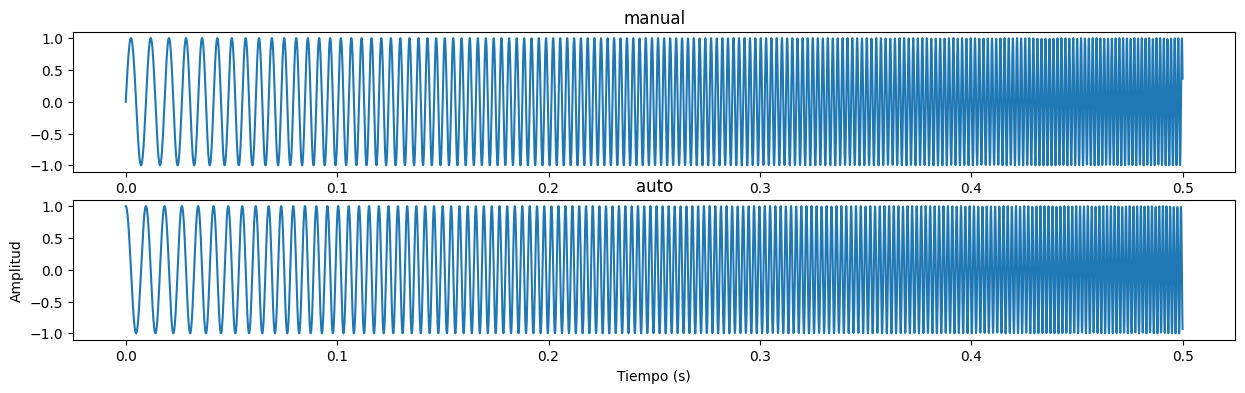

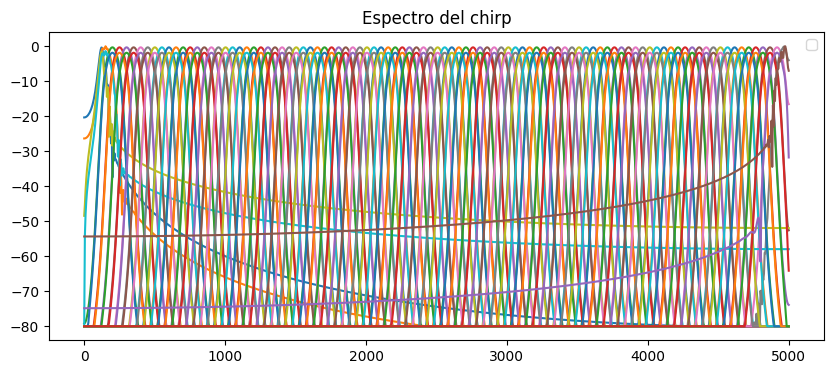

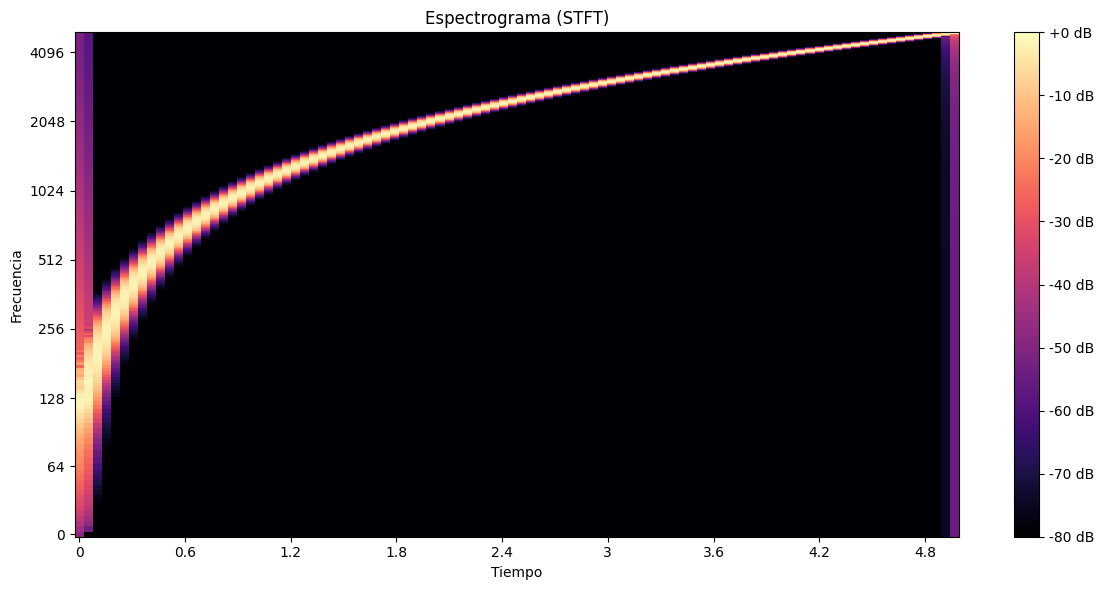

In [32]:
# Generar una señal Chirp de Delta segundos y fs como frecuencia de muestreo
Delta   = 5         # Duración (en s) de la señal generada
fs      = 10000     # Frecuencia de muestreo en Hz
f_inicial = 100     # Frecuencia inicial para el chirp
f_nyquist = fs // 2 # Frecuencia de Nyquist (frec final)
t = np.linspace(0, Delta, int(fs * Delta), endpoint=False)

# Chirp con funcion seno y con funcion chirp
chirp_manual = np.sin( 2 * np.pi * (f_inicial * t + (f_nyquist - f_inicial) / (2 * Delta) * t**2) )
chirp_auto = chirp(t, f0=f_inicial, f1=f_nyquist, t1=Delta, method='linear')

# Reproducir
audio_player_list([chirp_manual, chirp_auto], rates=[fs, fs])


# Graficar amplitudes de las señales
audios = [(chirp_manual, "manual"), (chirp_auto, "auto")]
f, axs = plt.subplots(2, figsize=(15, 4))
plot_size = 5000
for i, (a, label) in enumerate(audios):
    axs[i].set_title(label)
    axs[i].plot(t[:plot_size], a[:plot_size])
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()


# Espectro
# TODO: Arreglar esto!!!
plt.figure(figsize=(10, 4))
plt.title("Espectro del chirp")
for a, label in audios:
    S = np.abs(librosa.stft(a))
    D = librosa.amplitude_to_db(S, ref=np.max)
    frecs = np.linspace(0, fs/2, num=len(D))
    plt.plot(frecs, D)
    # plt.magnitude_spectrum(D, Fs=fs, scale='dB', label = label)
plt.legend()
plt.show()

# Espectrograma
S = librosa.stft(np.array(chirp_auto)) # Espectrograma con STFT
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=fs, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma (STFT)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

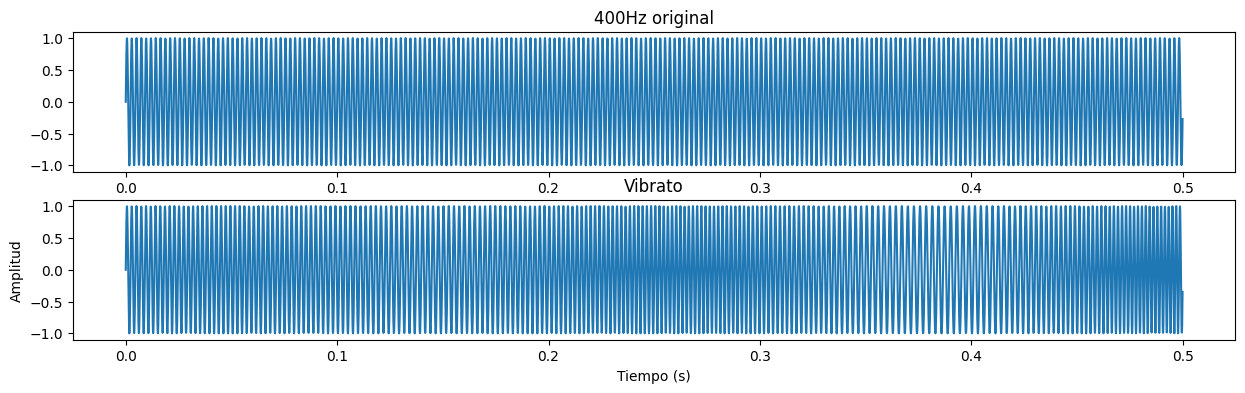

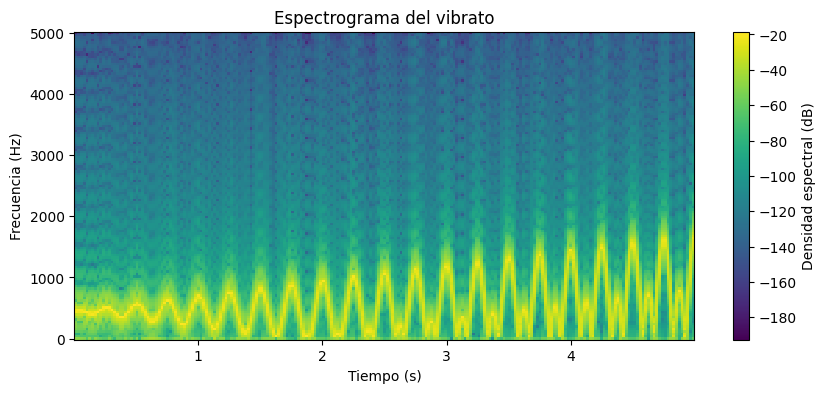

In [66]:
# Generar un vibrato (variación periódica en frecuencia de una señal)
f_nota  = 440   # Frecuencia de la nota 'La' en Hz 
f_mod   = 4     # Frecuencia de modulación del vibrato (Hz)
prof    = 10    # Profundidad del vibrato (Hz)
duracion= 4     # duracion en s de la señal generada 
t = np.linspace(0, Delta, int(fs * Delta), endpoint=False)

# Generar la señal original y la señal con vibrato
la_signal = np.sin(2*np.pi * f_nota * t)
vibrato = np.sin(2 * np.pi * (f_nota + prof * np.sin(2 * np.pi * f_mod * t)) * t)

# Reproducir las señales
audio_player_list([la_signal, vibrato], rates=[fs, fs])

# Graficar amplitudes de las señales
audios = [(la_signal, "400Hz original"), (vibrato, "Vibrato")]
f, axs = plt.subplots(2, figsize=(15, 4))
plot_size = 5000
for i, (a, label) in enumerate(audios):
    axs[i].set_title(label)
    axs[i].plot(t[:plot_size], a[:plot_size])
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()

# Espectrograma
f, t_spec, Sxx = spectrogram(vibrato, fs)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx))
plt.title("Espectrograma del vibrato")
plt.ylabel("Frecuencia (Hz)")
plt.xlabel("Tiempo (s)")
plt.colorbar(label='Densidad espectral (dB)')
plt.show()


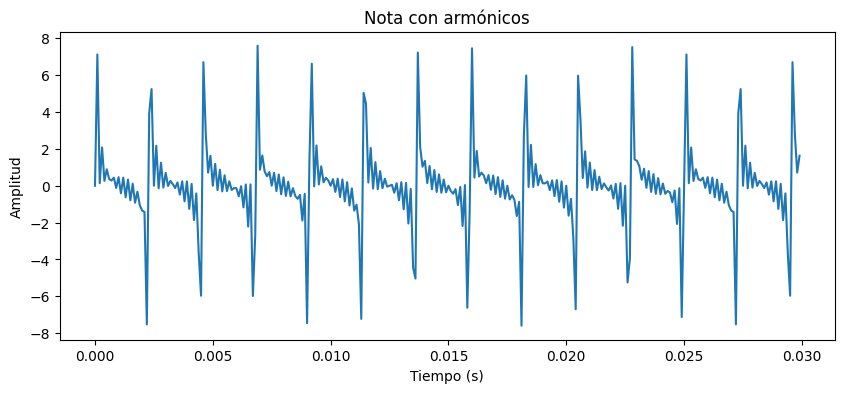

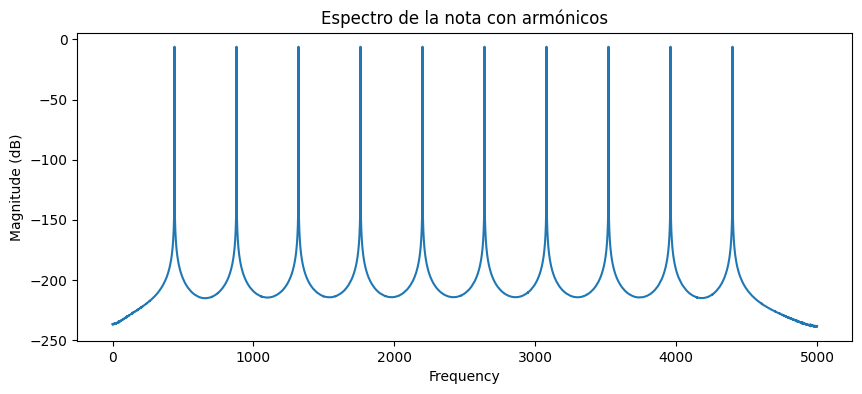

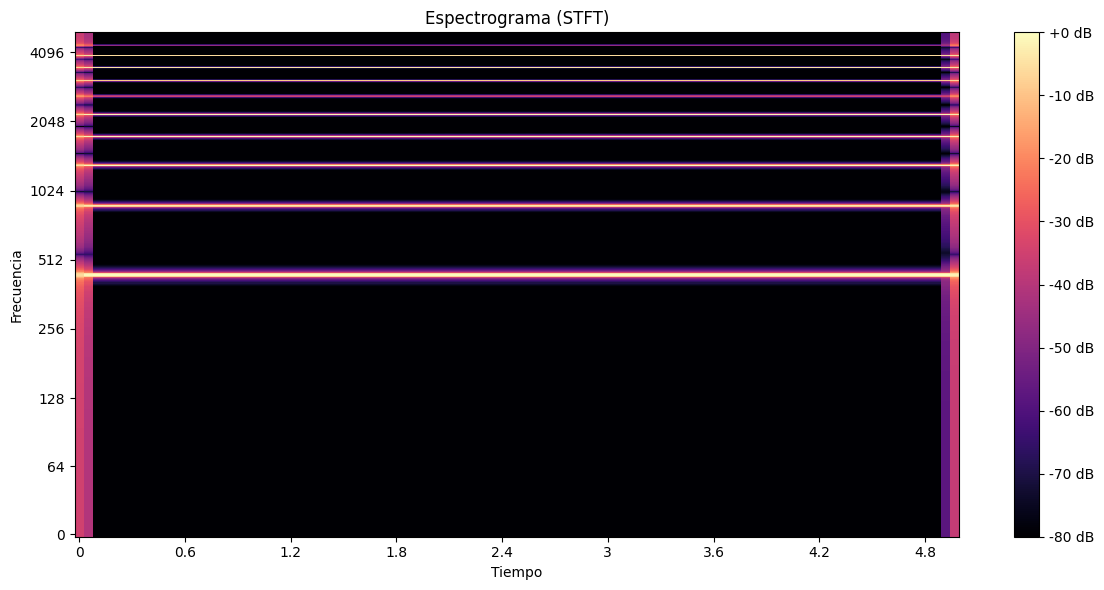

In [77]:
# Generar 10 armónicos de una nota base
f_nota  = 440   # Frecuencia de la nota 'La' en Hz 
duracion= 4     # duracion en s de la señal generada 
t = np.linspace(0, Delta, int(fs * Delta), endpoint=False)
harmonics = np.sum([np.sin(2 * np.pi * (k + 1) * f_nota * t) for k in range(10)], axis=0)

# Reproducir y graficar
audio_player_list([harmonics], rates= [fs])

plt.figure(figsize=(10, 4))
plot_size=300
plt.plot(t[:plot_size], harmonics[:plot_size])
plt.title("Nota con armónicos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.show()

# Espectro
plt.figure(figsize=(10, 4))
plt.magnitude_spectrum(harmonics, Fs=fs, scale='dB')
plt.title("Espectro de la nota con armónicos")
plt.show()

# Espectrograma
S = librosa.stft(harmonics) # Espectrograma con STFT
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=fs, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma (STFT)")
plt.xlabel("Tiempo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


----

2. **Operaciones algebraicas con imágenes**: ***Índice de vegetación NDVI***

   Dadas las siguientes imágenes obtenidas del satélite Landsat 7 de la zona de los [**montes Albanos**](https://www.esa.int/ESA_Multimedia/Images/2010/03/Band_1_Landsat_7_image_of_Alban_Hills) de la región italiana del Lacio ([**link**](https://goo.gl/maps/vamH5bW6jFc9VNEZ6)) obtenidas del catálogo [**Eduspace**](https://www.esa.int/SPECIALS/Eduspace_EN/SEMLK0F1EHH_0.html):
      1. Banda azul (B, *blue*): `data_RS/LS7_190_31_09062001_B01.tif`
      2. Banda verde (G, *green*): `data_RS/LS7_190_31_09062001_B02.tif`
      3. Banda roja (R, *red*): `data_RS/LS7_190_31_09062001_B03.tif`
      4. Banda infrarrojo cercano (NIR, *infrared*): `data_RS/LS7_190_31_09062001_B04.tif`

   * Muestra información de cada canal de la imagen: valor mínimo, máximo, mediana y valor medio.
   * Calcula el histograma para cada banda de la imagen multiespectral.
   * Combina las bandas para obtener una imagen RGB (*natural colour combination*): R(Banda roja), G(Banda verde), B(Banda azul)
   * Combina las bandas para obtener una imagen en falso color (*false colour combination*): R(Banda infrarrojo), G(Banda roja), B(Banda azul)
   * Calcula el índice de vegetación de diferencia normalizada NDVI (*Normalized Difference Vegetation Index*) [**link1**](https://es.wikipedia.org/wiki/%C3%8Dndice_de_vegetaci%C3%B3n_de_diferencia_normalizada), [**link2**](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php)

      $$NDVI = \frac{NIR-R}{NIR+R}$$

   **Ojo**: La operación de división puede provocar valores infinitos. Trata de solventar este problema.

In [4]:
# Channel information
def info_channel(im, im_name="imagen"):
    # Informacion de la imagen "im" cuyo nombre es "im_name" (parametro opcional)
    # Valores maximo, promedio, mediana y minimo de una imagen
    # Ejemplo: 
    # Dado R, canal rojo de una imagen RGB
    #   info_channel(R, 'R') nos da informacion de la imagen R de nombre "R"
    print('\nMax '+ im_name +': {m}'.format(m=im.max()))
    print('Mean '+ im_name + ': {m}'.format(m=im.mean()))
    print('Median '+ im_name + ': {m}'.format(m=np.median(im)))
    print('Min '+ im_name + ': {m}'.format(m=im.min()))

<hr style="border: 1px solid pink" />


Max R: 255
Mean R: 83.31200533333333
Median R: 82.0
Min R: 61

Max G: 255
Mean G: 72.43058133333334
Median G: 71.0
Min G: 37

Max B: 255
Mean B: 69.47580266666667
Median B: 68.0
Min B: 23

Max NIR: 255
Mean NIR: 104.2790488888889
Median NIR: 99.0
Min NIR: 11


<Figure size 640x480 with 0 Axes>

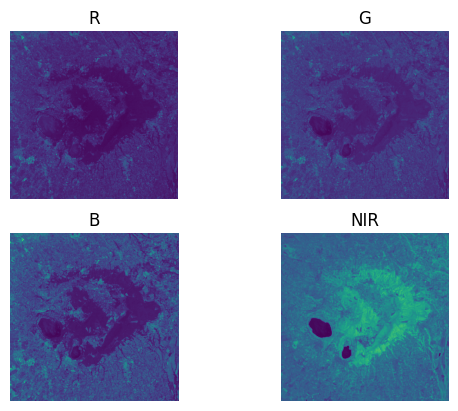

In [30]:
image_r = Image.open("../labs/data_RS/LS7_190_31_09062001_B01.tif")
image_g = Image.open("../labs/data_RS/LS7_190_31_09062001_B02.tif")
image_b = Image.open("../labs/data_RS/LS7_190_31_09062001_B03.tif")
image_i = Image.open("../labs/data_RS/LS7_190_31_09062001_B04.tif")
images = [(image_r, "R"), (image_g, "G"), (image_b, "B"), (image_i, "NIR")]

plt.tight_layout()
f, axs = plt.subplots(2, 2)
for ax, m in zip(axs.flatten(), images):
    ax.imshow(m[0])
    ax.set_title(m[1])
    ax.axis('off')
    info_channel( np.array(m[0].convert("RGB")), im_name=m[1] )


----

3. **Cuantización del color**: Reduce el color de la imagen que se encuentra en la dirección:
      + [**Imagen 1**](https://imgs.mongabay.com/wp-content/uploads/sites/20/2016/10/01181527/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg) 
      + [**Imagen 2**](https://eoimages.gsfc.nasa.gov/images/imagerecords/6000/6811/Brazil_TMO_2006179_lrg.jpg)
      + [**Imagen 3**](https://live.staticflickr.com/861/28779502307_dba5f6070f_c_d.jpg)
      + [**Imagen 4**](https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150656/southpacific_vir_2022325_lrg.jpg)

In [ ]:
# Selecciona aleatoriamente la imagen.
# Lee la imagen: io.imread()
# Redimensiona la imagen a un tamano de 450x450: transform.resize()
# Imprime la informacion de la imagen y de sus canales ['R', 'G', 'B']: 
#       nombre de la imagen, dimensiones, valor minimo y maximo para cada canal de la imagen
# Cuantifica los colores (4 colores)
# Cuantifica los colores (8 colores)
# Visualiza la imagen original y las imagenes con menos colores (4 y 8 colores)
# Dibuja en un diagrama de barras (bar) o en una grafica de pastel (pie) el numero de pixeles que corresponden a los 4 u 8 colores utilizados



### Notas sobre la cuantificacion de color

# Para la cuantificación de los colores puedes utilizar la la funcióon quantify_colors() 
# que se encuentra en el fichero `code/f_color.py`

# from f_color import quantify_colors



### Notas sobre las imagenes

# https://imgs.mongabay.com/wp-content/uploads/sites/20/2016/10/01181527/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg
# Amazonas

# https://eoimages.gsfc.nasa.gov/images/imagerecords/6000/6811/Brazil_TMO_2006179_lrg.jpg
# Amazonas

# https://live.staticflickr.com/861/28779502307_dba5f6070f_c_d.jpg
# https://www.flickr.com/photos/europeanspaceagency/28779502307/
# Sharm El Sheikh

# https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150656/southpacific_vir_2022325_lrg.jpg
# Pacifico Sur
# Informacion de una imagen

In [ ]:
# Informacion de una imagen
def print_sumario(im, im_name, ch_names):
    # Informacion de la imagen "im" cuyo nombre es "im_name" y 
    # ch_names=['R', 'G', 'B'] son los nombres de las bandas
    # Ejemplo: 
    #   print_sumario(im, str(seleccionada), ['R', 'G', 'B'])
    print('--------------')
    print('Detalles de la imagen: '+im_name)
    print('--------------')
    print(f'Dimensiones de la imagen: {im.shape}')
    print('Canales:')
    
    if len(ch_names) == 1:
        im = im[..., np.newaxis]
        
    for i, lab in enumerate(ch_names):
        min_val = np.min(im[:,:,i])
        max_val = np.max(im[:,:,i])
        print(f'{lab} : min={min_val:.4f}, max={max_val:.4f}')

<hr style="border: 1px solid pink" />

In [ ]:
# Realiza la tarea

In [ ]:
imagenes = ["https://imgs.mongabay.com/wp-content/uploads/sites/20/2016/10/01181527/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg",
                  "https://eoimages.gsfc.nasa.gov/images/imagerecords/6000/6811/Brazil_TMO_2006179_lrg.jpg",
                  "https://live.staticflickr.com/861/28779502307_dba5f6070f_c_d.jpg",
                  "https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150656/southpacific_vir_2022325_lrg.jpg"]

def im_open_remote(url):
    result = requests.get(url)
    with open("temporal.jpg", 'wb') as f:
        f.write(result.content)
    im = io.imread("temporal.jpg")
    return im

# Selecciona aleatoriamente una de las cuatro imagenes
seleccionada = get_random_number([0, 3])
print(seleccionada)
url = imagenes[seleccionada]
im = im_open_remote(url)

##

----

4. Utiliza los siguientes filtros para realizar un filtrado de la señal `data_ECG/ecg.wav`:
    1.  Un filtro paso bajo de $50$ Hz
    2.  Un filtro paso alto de $20$ Hz
    3.  Un filtro paso banda de $10-50$ Hz
    
    Visualiza también los espectros de la señal original y de las filtradas.

<hr style="border: 1px solid pink" />

In [ ]:
# Realiza la tarea

In [ ]:
# scipy.io == sp_io

fs, x = sp_io.wavfile.read('data_ECG/ecg.wav')
x = x.astype(float)

----

5. **Procesamiento de imágenes**
  
    Realiza las siguientes tareas.
    + Selecciona la imagen de forma aleatoria (directorio: `images_RGB` o `images_RGB_channels`) mediante la función: `get_random_image_path()`.
    + Pasa la imagen a escala de grises.
    + Modifica:
      + Saturación de la imagen (con un factor entre 2-3)
      + Brillo de la imagen (un $40\%$ más de brillo y un $20\%$ menos de brillo)
      + Contraste de la imagen (aumenta y disminuye el contraste de la imagen)
    + Obtén el negativo de la imagen y rótala $180^\circ$.
    + Extender o reducir el histograma para ver aumentar el contraste de la imagen (entre el percentil $2$ y el percentil $98$).
    + Ecualiza el histograma y visualiza la imagen original y la imagen después de ecualizar el histograma.
    + Introduce un poco de ruido en la imagen y, después, para eliminar este ruido utiliza:
      + Un filtro de suavizado
      + Un filtro de realce
      + Un filtro gaussiano en el dominio frecuencial
      + ...
    + Aplica alguna operación morfológica en la imagen o una concatenación de ellas.

    Si lo deseas puedes utilizar la misma imagen para todas las operaciones o cambiarla para alguna de las operaciones en concreto. Si cambias la imagen, explica porqué lo has hecho.

    También puedes realizar todas las tareas de procesamiento de una imagen que te proponemos o realizar variaciones que puedas explicar detalladamente.

<hr style="border: 1px solid pink" />

In [ ]:
seleccionada = get_random_image_path('images_RGB_channels')
print(seleccionada)

In [ ]:
# Realiza la tarea

# GRAYSCALE

# SATURACION

# BRILLO

# CONTRASTE

# NEGATIVO

# ROTACION

# EXTENSION DEL HISTOGRAMA

# ECUALIZACION DEL HISTOGRAMA

# IMAGEN CON RUIDO

# ELIMINACION DE RUIDO

# OPERACION MORFOLOGICA

----

6. En este ejercicio puedes realizar una de las siguientes tareas (a tu elección):
   1. *Pitch tracking*
   2. Análisis del tempo
   3. Detección de picos
   4. Detección de *onsets*

    Selecciona aleatoriamente una canción del directorio `audio_tempo` y toma solamente los primeros segundos de la canción (por ejemplo, los 6 primeros segundos).

<hr style="border: 1px solid pink" />

In [ ]:
# Realiza la tarea

seleccionada = get_random_audio_path('audio_tempo/')
print(seleccionada)

x, fs = librosa.load(seleccionada)
tf = librosa.time_to_samples(6.0, sr=fs) # int(6.0*fs)
x6 = x[0:tf]
ipd.Audio(x6, rate=fs)

----

7. **Características de una señal de voz**

    1. Selecciona aleatoriamente una señal del directorio `audio_voz`:
        <center>

        Señales disponibles `sp01.wav`, `sp02.wav`, ..., `sp08.wav`

        <center/>
        
    2. Calcula las características de una señal tales como promedio, desviación estándar, mediana, moda, ..., la energía de tiempo corto (*short-time energy*), la magnitud de tiempo corto (*short-time magnitude*) y la tasa de cruces por el cero de tiempo corto (*short-time zero-crossing rate*, ZCR).
    3. Utiliza dos tipos de espectrogramas (*wideband* y *narrowband*) y analiza los resultados según el tipo de espectrograma.
    4. Visualiza el espectrograma de escala Mel. 
    5. Obtén los coeﬁcientes cepstrales en las frecuencias de Mel (*Mel Frequency Cepstral Coeﬃcients*, MFCC).

    

<hr style="border: 1px solid pink" />

In [ ]:
# Selecciona aleatoriamente uno de los ocho audios
seleccionada = get_random_number([1, 8])
print(seleccionada)

In [ ]:
# Realiza la tarea

# Obtén el promedio, desviación estándar, mediana y moda
# short-time energy
# short-time magnitude
# ZCR
# Espectrograma wideband
# Espectrograma narrowband
# Espectrograma de escala mel
# MFCCs de la señal

<hr style="border: 1px solid pink" />